In [1]:
import duckdb
from config import CONFIG

import pandas as pd
from pathlib import Path
import duckdb
import sys, os
from dotenv import load_dotenv
from urllib.parse import quote_plus

sys.path.append(os.path.abspath(".."))
from utils.utils import data_add_moer
import pyarrow as pa
import pyarrow.parquet as pq
import psycopg2
import shutil
import gc

load_dotenv()

user = quote_plus(os.getenv("CLIMATETRACE_USER"))
password = quote_plus(os.getenv("CLIMATETRACE_PASS"))
host = os.getenv("CLIMATETRACE_HOST")
port = os.getenv("CLIMATETRACE_PORT")
database = os.getenv("CLIMATETRACE_DB")

postgres_url = f"postgresql://{user}:{password}@{host}:{port}/{database}"

In [ ]:
asset_path = CONFIG['annual_asset_path']
gadm_1_path = CONFIG['gadm_1_path']
gadm_0_path = CONFIG['gadm_0_path']
gadm_2_path = CONFIG['gadm_2_path']

In [ ]:
# ------------------------------------- GADM_1 Reductions Summary Query



# country-continent-region-sector-subsector-activity-emissions-net_reduction
# country-state-subsector
# city-subsector? if cant do subsector do sector

con = duckdb.connect()

# one tab state, one tab for city
query = f'''


with assets as (
    select asset_id
        , iso3_country
        , country_name
        , continent
        , eu
        , oecd
        , unfccc_annex
        , developed_un
        , gadm_1
        , sector
        , subsector
        , old_activity activity_2024
        , sum(emissions_quantity) asset_emissions
        , emissions_reduced_at_asset
        , total_emissions_reduced_per_year
    
    from '{asset_path}' ae
    
    --where reduction_q_type = 'asset'

    group by asset_id
        , iso3_country
        , country_name
        , continent
        , eu
        , oecd
        , unfccc_annex
        , developed_un
        , gadm_1
        , sector
        , subsector
        , old_activity
        , emissions_reduced_at_asset
        , total_emissions_reduced_per_year
),

asset_agg as (
    select iso3_country
        , country_name
        , continent
        , eu
        , oecd
        , unfccc_annex
        , developed_un
        , gadm_1
        , sector
        , subsector
        , sum(activity_2024) activity_2024
        , sum(asset_emissions) asset_emissions
        , sum(emissions_reduced_at_asset) emissions_reduced_at_asset
        , sum(total_emissions_reduced_per_year) total_emissions_reduced_per_year

    from assets

    group by iso3_country
        , country_name
        , continent
        , eu
        , oecd
        , unfccc_annex
        , developed_un
        , gadm_1
        , sector
        , subsector
),

gadm_inventory as (
    select gadm_id
        , gid
        , iso3_country
        , country_name
        , gadm_1_name
        , gadm_1_corrected_name
        , continent
        , eu
        , oecd
        , unfccc_annex
        , developed_un
        , sector
        , subsector
        , sum(emissions_quantity) emissions_quantity

    from '{gadm_1_path}'
    
    group by gadm_id
        , gid
        , iso3_country
        , country_name
        , gadm_1_name
        , gadm_1_corrected_name
        , continent
        , eu
        , oecd
        , unfccc_annex
        , developed_un
        , sector
        , subsector
)

select coalesce(aa.iso3_country, gi.iso3_country) iso3_country
    , coalesce(aa.country_name, gi.country_name) country_name
    , coalesce(aa.gadm_1, gi.gadm_id) gadm_id
    --, gi.gadm_1_name 
    , gi.gadm_1_corrected_name
    --, gi.gid
    , coalesce(aa.continent, gi.continent) continent
    --, coalesce(aa.eu, gi.eu) eu
    --, coalesce(aa.oecd, gi.oecd) oecd
    --, coalesce(aa.unfccc_annex, gi.unfccc_annex) unfccc_annex
    --, coalesce(aa.developed_un, gi.developed_un) developed_un
    , coalesce(aa.sector, gi.sector) sector
    , coalesce(aa.subsector, gi.subsector) subsector
    , aa.activity_2024 asset_activity_2024
    , aa.asset_emissions
    , gi.emissions_quantity - aa.asset_emissions remainder_emissions
    , gi.emissions_quantity
    , aa.emissions_reduced_at_asset
    , aa.total_emissions_reduced_per_year

from asset_agg aa
full outer join gadm_inventory gi
    on aa.gadm_1 = gi.gadm_id
    and aa.subsector = gi.subsector
'''

df = con.execute(query).df()

df.to_csv("gadm_reductions_try3.csv", index=False)

con.close()

In [ ]:
# ---------------------------------------- CITY REDUCTIONS


asset_path = CONFIG['annual_asset_path']
city_path = CONFIG['city_path']

con = duckdb.connect()

query = f'''
    with assets as (
    select asset_id
        , iso3_country
        , country_name
        , continent
        , eu
        , oecd
        , unfccc_annex
        , developed_un
        , ghs_fua
        , sector
        , old_activity activity_2024
        , sum(emissions_quantity) asset_emissions
        , emissions_reduced_at_asset
        , total_emissions_reduced_per_year
    
    from '{asset_path}' ae
    
    where reduction_q_type = 'asset'
        and len(ghs_fua) > 0

    group by asset_id
        , iso3_country
        , country_name
        , continent
        , eu
        , oecd
        , unfccc_annex
        , developed_un
        , ghs_fua
        , sector
        , old_activity
        , emissions_reduced_at_asset
        , total_emissions_reduced_per_year
),

asset_agg as (
    select iso3_country
        , country_name
        , continent
        , eu
        , oecd
        , unfccc_annex
        , developed_un
        , ghs_fua
        , sector
        , sum(activity_2024) activity_2024
        , sum(asset_emissions) asset_emissions
        , sum(emissions_reduced_at_asset) emissions_reduced_at_asset
        , sum(total_emissions_reduced_per_year) total_emissions_reduced_per_year

    from assets

    group by iso3_country
        , country_name
        , continent
        , eu
        , oecd
        , unfccc_annex
        , developed_un
        , ghs_fua
        , sector
),

city_inventory as (
    select iso3_country
        , country_name
        , city_id
        , corrected_name
        , continent
        , sector
        , sum(emissions_quantity) emissions_quantity

    from '{city_path}'

    group by iso3_country
        , country_name
        , city_id
        , corrected_name
        , continent
        , sector
)

select coalesce(aa.iso3_country, ci.iso3_country) iso3_country
    , coalesce(aa.country_name, ci.country_name) country_name
    , COALESCE(CAST(aa.ghs_fua AS VARCHAR), ci.city_id) city_id
    , ci.corrected_name
    , coalesce(aa.continent, ci.continent) continent
    , coalesce(aa.sector, ci.sector) sector
    , aa.activity_2024 asset_activity_2024
    , aa.asset_emissions
    , ci.emissions_quantity - aa.asset_emissions remainder_emissions
    , ci.emissions_quantity
    , aa.emissions_reduced_at_asset
    , aa.total_emissions_reduced_per_year

from asset_agg aa
full outer join city_inventory ci
    ON aa.ghs_fua[1] = ci.city_id
    and aa.sector = ci.sector

'''

df = con.execute(query).df()

df.to_csv("city_reductions.csv", index=False)

con.close()



In [ ]:
city_path = CONFIG['city_path']
con = duckdb.connect()

query = f'''
    select distinct asset_id
        , iso3_country
        , gadm_1
        , subsector

    from '{asset_path}'

    where iso3_country <> LEFT(gadm_1, 3)
'''

df = con.execute(query).df()

df.to_csv("iso_gadm_mismatch.csv",index=False)

In [ ]:
import pandas as pd

# Read parquet
df = pd.read_parquet("data/percentile_moer/asset_moer_2023.parquet")

# Save as CSV
df.to_csv("moer_file.csv", index=False)

In [ ]:
import duckdb

annual_asset_path = CONFIG['annual_asset_path']
gadm_0_path = CONFIG['gadm_0_path']
gadm_1_path = CONFIG['gadm_1_path']
gadm_2_path = CONFIG['gadm_2_path']

con = duckdb.connect()

query_sector_assets_sql = f'''
        SELECT 
            ae.year,
            ae.asset_id,
            ae.asset_name,
            ae.iso3_country,
            ae.country_name,
            ae.balancing_authority_region,
            ae.continent,
            ae.eu,
            ae.oecd,
            ae.unfccc_annex,
            ae.developed_un,
            ae.em_finance,
            ae.sector,
            ae.subsector,
            gadm0.gid_0,
            ae.gadm_1,
            gadm1.gid_1,
            gadm1.gadm_1_name,
            ae.gadm_2,
            gadm2.gid_2,
            gadm2.gadm_2_name,
            ae.activity_units,
            ae.strategy_name,
            CASE WHEN BOOL_OR(ae.activity_is_temporal) THEN SUM(ae.activity) ELSE AVG(ae.activity) end AS activity,
            SUM(ae.capacity) AS capacity,
            SUM(ae.emissions_quantity) AS emissions_quantity,
            SUM(ae.emissions_quantity) / NULLIF(SUM(ae.activity), 0) AS emissions_factor,
            ae.emissions_reduced_at_asset AS asset_reduction_potential,
            ae.total_emissions_reduced_per_year AS net_reduction_potential
        FROM '{annual_asset_path}' ae
        LEFT JOIN (
            SELECT DISTINCT
                gid AS gid_0, 
                iso3_country 
            FROM '{gadm_0_path}'
            ) gadm0
        ON ae.iso3_country = gadm0.iso3_country
        LEFT JOIN (
            SELECT DISTINCT
                gid AS gid_1,
                gadm_id AS gadm_1,
                gadm_1_corrected_name AS gadm_1_name
            FROM '{gadm_1_path}'
            ) gadm1
        ON ae.gadm_1 = gadm1.gadm_1
        LEFT JOIN (
            SELECT DISTINCT
                gid AS gid_2,
                gadm_2_id AS gadm_2,
                gadm_2_corrected_name AS gadm_2_name
            FROM '{gadm_2_path}'
        ) gadm2
        ON ae.gadm_2 = gadm2.gadm_2
        WHERE 
            subsector = 'solid-waste-disposal'
            AND year = 2024
        GROUP BY
            ae.year,
            ae.asset_id,
            ae.asset_name,
            ae.iso3_country,
            ae.country_name,
            ae.balancing_authority_region,
            ae.continent,
            ae.eu,
            ae.oecd,
            ae.unfccc_annex,
            ae.developed_un,
            ae.em_finance,
            ae.sector,
            ae.subsector,
            gadm0.gid_0,
            ae.gadm_1,
            gadm1.gid_1,
            gadm1.gadm_1_name,
            ae.gadm_2,
            gadm2.gid_2,
            gadm2.gadm_2_name,
            ae.activity_units,
            ae.strategy_name,
            ae.emissions_reduced_at_asset,
            ae.total_emissions_reduced_per_year
    '''

df = con.execute(query_sector_assets_sql).df()

df.to_csv("abatement_curve_troubleshoot.csv",index=False)

In [ ]:
asset_ss_path = CONFIG['asset_emissions_country_subsector_path']

con = duckdb.connect()

query = f'''
    select count(distinct asset_id)
    from '{asset_path}'
    where iso3_country is null
'''

df = con.execute(query).df()

#print(df)

print(df)

In [ ]:
import duckdb
import pyarrow.parquet as pq
import math

# Merge or read the full dataset
df = duckdb.sql("""
    SELECT * FROM read_parquet('data/asset_emissions/asset_level_2024/asset_annual_emissions_moer_chunk_*.parquet')
""").df()

# Estimate chunk size — make 25 MB-ish chunks
rows_per_chunk = math.ceil(len(df) / 24)  # 24 chunks instead of 12

for i, start in enumerate(range(0, len(df), rows_per_chunk), start=1):
    df_chunk = df.iloc[start : start + rows_per_chunk]
    out_path = f"data/asset_emissions/asset_level_2024/asset_annual_emissions_moer_chunk_{i:02}.parquet"
    df_chunk.to_parquet(out_path, compression="snappy")
    print("Wrote", out_path)

In [ ]:
import pandas as pd

df = pd.read_csv("data/strategy/categorical_scores/ct_ers_all_pivots_20251018.csv")

df.to_parquet("data/strategy/categorical_scores/strategy_categorical_scores.parquet", index=False)

In [ ]:
import duckdb
con = duckdb.connect()

cat = con.execute("""
   SELECT distinct strategy_name
                  , strategy_description
                  , original_inventory_sector
                  , confidence
                  , confidence_score
                  , confidence_multiplier
                  , feasibility
                  , feasibility_score
                  , feasibility_multiplier
                  , cost
                  , cost_score
                  , cost_multiplier
   
   FROM read_parquet('data/strategy/categorical_scores/strategy_categorical_scores.parquet')
""").df()

cat.to_csv("categorical_condensed.csv",index=False)


In [ ]:
df = con.execute(f'''
                 select e.*
                    , c.confidence
                    , c.confidence_score
                    , c.confidence_multiplier
                    , c.feasibility
                    , c.feasibility_score
                    , c.feasibility_multiplier
                    , c.cost
                    , c.cost_score
                    , c.cost_multiplier

                 from read_parquet('data/zzz_landing_zone/effectiveness.parquet') e
                 left join (
                    SELECT distinct strategy_name
                        , strategy_description
                        , original_inventory_sector
                        , confidence
                        , confidence_score
                        , confidence_multiplier
                        , feasibility
                        , feasibility_score
                        , feasibility_multiplier
                        , cost
                        , cost_score
                        , cost_multiplier
                    from read_parquet('data/strategy/categorical_scores/strategy_categorical_scores.parquet')
                  ) c 
                    on e.strategy_name = c.strategy_name
                    and e.strategy_description = c.strategy_description
                    and e.subsector = c.original_inventory_sector
                 
                 ''').df()

df.to_csv("combined_scores.csv",index=False)

In [ ]:
con = duckdb.connect()

df = con.execute(f'''
                 select count(distinct gadm_2_id) from '{gadm_2_path}'

                 ''').df()
print(df)

con.close()

In [ ]:
# -------------------------------- this is asset level scoring! ------------------------------------

# ------------------------------------ ERS STRATEGY SCORE ---------------------------------------

parquet_path = "original_method_average_3_scores.parquet"

con = duckdb.connect()

print('Query Running: Getting effectiveness score for assets')
con.execute(f'''
    INSTALL postgres;
    LOAD postgres;

        CREATE TEMP TABLE rdf as
        select rdf.*
                , coalesce(rdf.asset_output, 'other') asset_output_fixed
                , cs.confidence
                , cs.confidence_score
                , cs.feasibility
                , cs.feasibility_score
                , cs.cost
                , cs.cost_score as cost_score

        FROM postgres_scan('{postgres_url}', 'public', 'reductions_data_fusion') rdf
        inner join (
                select distinct asset_id

                from postgres_scan('{postgres_url}', 'public', 'asset_emissions_data_fusion')

                where (start_time >= '2024-01-01'
                        and start_time <= '2024-12-01')
                        and most_granular = true
                        and gas = 'co2e_100yr'
        ) mg
                on mg.asset_id = rdf.asset_id
        LEFT JOIN read_parquet('data/strategy/categorical_scores/strategy_categorical_scores.parquet') cs
                on cs.strategy_id = rdf.strategy_id 

        where rdf.strategy_rank = 1
                and rdf.gas = 'co2e_100yr';

    COPY (
        WITH asset_rf AS (
                SELECT
                        asset_id
                        , asset_output_fixed asset_output
                        , strategy_name
                        , strategy_description
                        , iso3_country
                        , original_inventory_sector AS subsector
                        , old_emissions_factor
                        , old_activity
                        , total_emissions_reduced_per_year
                        , (total_emissions_reduced_per_year / old_activity) AS reduction_factor
                        , (old_emissions_factor * old_activity) AS w_inventory
                        , confidence
                        , confidence_score
                        , feasibility
                        , feasibility_score
                        , cost
                        , cost_score
                
                FROM rdf
                
                WHERE total_emissions_reduced_per_year IS NOT NULL
                        AND old_activity IS NOT NULL
                        AND old_activity > 0
                ),

        subsector_stats AS (
                SELECT
                        subsector
                        , asset_output
                        , SUM(w_inventory) AS subsector_emissions_inventory
                       
                        , SUM(total_emissions_reduced_per_year) / NULLIF(SUM(old_activity), 0) AS mu_rf
                        --, avg(reduction_factor) mu_rf
                        --, stddev_samp(reduction_factor) sigma_rf
                        , SQRT(
                                GREATEST(
                                        SUM(old_activity * POWER(reduction_factor, 2)) / NULLIF(SUM(old_activity), 0)
                                                - POWER( SUM(old_activity * reduction_factor) / NULLIF(SUM(old_activity), 0), 2 ),
                                0
                        )
                        ) AS sigma_rf
                
                FROM asset_rf
                
                GROUP BY subsector
                        , asset_output
        ),

        rf_score as (
                
                SELECT
                        a.asset_id
                        , a.asset_output
                        , a.strategy_name
                        , a.strategy_description
                        , a.iso3_country
                        , a.subsector
                        , a.old_emissions_factor
                        , a.old_activity
                        , a.total_emissions_reduced_per_year
                        , a.reduction_factor
                        , a.w_inventory
                        , s.mu_rf
                        , s.sigma_rf
                        , CASE
                                WHEN s.sigma_rf IS NULL OR s.sigma_rf < 1e-12 THEN 0.0
                                ELSE (a.reduction_factor - s.mu_rf) / s.sigma_rf
                        END AS asset_rf_zscore
                        
                        , CASE 
                                WHEN s.sigma_rf IS NULL OR s.sigma_rf < 1e-12 THEN 3.0
                                ELSE 
                                GREATEST(1.0, LEAST(5.0,
                                6.0 - (
                                        ((CASE 
                                        WHEN (a.reduction_factor - s.mu_rf) / s.sigma_rf < -3 THEN -3
                                        WHEN (a.reduction_factor - s.mu_rf) / s.sigma_rf > 3 THEN 3
                                        ELSE (a.reduction_factor - s.mu_rf) / s.sigma_rf
                                        END) * (4.0 / 6.0) + 3.0)  -- note: +3.0 (not +1.0)
                                )
                                ))
                        END AS asset_rf_score
                        
                        , confidence
                        , confidence_score
                        , feasibility
                        , feasibility_score
                        , cost
                        , cost_score

                FROM asset_rf a
                JOIN subsector_stats s 
                        on a.subsector = s.subsector
                        and a.asset_output = s.asset_output
        ),

        combined_score as (
                select *
                        ,  ROUND((
                                asset_rf_score + feasibility_score + cost_score
                        ) / 3.0, 2) AS combined_score

                from rf_score
        ),

        opportunity_rank AS (
                SELECT *,
                        RANK() OVER (
                        PARTITION BY combined_score
                        ORDER BY total_emissions_reduced_per_year DESC  -- Higher emitters get higher rank
                        ) AS tie_break_rank,
                        COUNT(*) OVER (
                        PARTITION BY combined_score
                        ) AS bucket_size
                FROM combined_score
        ),

        opportunity_score_final AS (
                SELECT *,
                        -- number of digits in bucket size
                        LENGTH(CAST(bucket_size AS TEXT)) AS bucket_digits,

                        -- adjusted opportunity score: preserve 3 base decimals, append rank digits
                        CAST(combined_score AS DOUBLE)
                                + (
                                        CAST(tie_break_rank AS DOUBLE)
                                                / POWER(10.0, LENGTH(CAST(bucket_size AS TEXT)) + 2)
                        ) AS opportunity_score
                FROM opportunity_rank
        )

        SELECT
                asset_id,
                strategy_name,
                strategy_description,
                iso3_country,
                subsector,
                asset_rf_score,
                feasibility_score,
                cost_score,
                combined_score,
                total_emissions_reduced_per_year,
                tie_break_rank,
                bucket_size,
                opportunity_score AS opportunity_score
        
        FROM opportunity_score_final

        -- WHERE subsector in ('solid-waste-disposal', 'iron-and-steel', 'cement', 'electricity-generation', 'water-reservoirs')
        
        ORDER BY opportunity_score ASC
        
                                         
    
    ) TO '{parquet_path}' (FORMAT PARQUET);
''')


con.close()

In [ ]:
df = pd.read_parquet("asset_opportunity_score_feasibility_cost_baseline.parquet")
df.to_csv("asset_opportunity_score_feasibility_cost_baseline.csv",index=False)

In [ ]:
# -------------------------------- asset level scoring FEASIBILITY/COST BASELINE ------------------------------------

# ------------------------------------ ERS STRATEGY SCORE ---------------------------------------

parquet_path = "simple_average.parquet"

con = duckdb.connect()

print('Query Running: Getting effectiveness score for assets')
con.execute(f'''
        INSTALL postgres;
        LOAD postgres;

        CREATE TEMP TABLE rdf as
            

        select rdf.*
                , coalesce(rdf.asset_output, 'other') asset_output_fixed
                , cs.confidence
                , cs.confidence_score
                , cs.feasibility
                , cs.feasibility_score
                , cs.cost
                , cs.cost_score as cost_score

        FROM postgres_scan('{postgres_url}', 'public', 'reductions_data_fusion') rdf
        inner join (
                select distinct asset_id

                from postgres_scan('{postgres_url}', 'public', 'asset_emissions_data_fusion')

                where (start_time >= '2024-01-01'
                        and start_time <= '2024-12-01')
                        and most_granular = true
                        and gas = 'co2e_100yr'
        ) mg
                on mg.asset_id = rdf.asset_id
        LEFT JOIN read_parquet('data/strategy/categorical_scores/strategy_categorical_scores.parquet') cs
                on cs.strategy_id = rdf.strategy_id 

        where rdf.strategy_rank = 1
                and rdf.gas = 'co2e_100yr';


    COPY (
        WITH asset_rf AS (
                SELECT
                        asset_id
                        , asset_output_fixed asset_output
                        , strategy_name
                        , strategy_description
                        , iso3_country
                        , original_inventory_sector AS subsector
                        , old_emissions_factor
                        , old_activity
                        , total_emissions_reduced_per_year
                        , (total_emissions_reduced_per_year / old_activity) AS reduction_factor
                        , baseline_emissions AS w_inventory
                        , confidence
                        , confidence_score
                        , feasibility
                        , feasibility_score
                        , cost
                        , cost_score
                
                FROM rdf
                
                WHERE total_emissions_reduced_per_year IS NOT NULL
                        AND old_activity IS NOT NULL
                        AND old_activity > 0
                ),

        subsector_stats AS (
                SELECT
                        subsector
                        , asset_output
                        , SUM(w_inventory) AS subsector_emissions_inventory
                       
                        --, SUM(total_emissions_reduced_per_year) / NULLIF(SUM(old_activity), 0) AS mu_rf
                        , avg(reduction_factor) mu_rf
                        , stddev_samp(reduction_factor) sigma_rf
                        --, SQRT(
                        --        GREATEST(
                        --                SUM(old_activity * POWER(reduction_factor, 2)) / NULLIF(SUM(old_activity), 0)
                        --                       - POWER( SUM(old_activity * reduction_factor) / NULLIF(SUM(old_activity), 0), 2 ),
                        --        0
                        --)
                        --) AS sigma_rf
                
                FROM asset_rf
                
                GROUP BY subsector
                        , asset_output
        ),

        rf_score as (
                
                SELECT
                        a.asset_id
                        , a.asset_output
                        , a.strategy_name
                        , a.strategy_description
                        , a.iso3_country
                        , a.subsector
                        , a.old_emissions_factor
                        , a.old_activity
                        , a.total_emissions_reduced_per_year
                        , a.reduction_factor
                        , a.w_inventory
                        , s.mu_rf
                        , s.sigma_rf
                        , CASE
                                WHEN s.sigma_rf IS NULL OR s.sigma_rf < 1e-12 THEN 0.0
                                ELSE (a.reduction_factor - s.mu_rf) / s.sigma_rf
                        END AS asset_rf_zscore
                        
                        , CASE
                                WHEN s.sigma_rf IS NULL OR s.sigma_rf < 1e-12 THEN 0.0
                                ELSE
                                GREATEST(-2.0, LEAST(2.0,
                                -1 * (                 -- invert so high z = good becomes low score
                                        CASE
                                                WHEN (a.reduction_factor - s.mu_rf) / s.sigma_rf < -3 THEN -3
                                                WHEN (a.reduction_factor - s.mu_rf) / s.sigma_rf > 3 THEN 3
                                                ELSE (a.reduction_factor - s.mu_rf) / s.sigma_rf
                                        END
                                        * (2.0 / 3.0)        -- scale ±3 → ±2
                                )
                                ))
                        END AS asset_rf_score
                        
                        , confidence
                        , confidence_score
                        , feasibility
                        , feasibility_score
                        , cost
                        , cost_score

                FROM asset_rf a
                JOIN subsector_stats s 
                        on a.subsector = s.subsector
                        and a.asset_output = s.asset_output
        ),

        rf_rounded as (
                select *
                        ,  ROUND(asset_rf_score, 2) AS rf_rounded

                from rf_score
        ),

        rf_rank AS (
                SELECT *,
                        RANK() OVER (
                                PARTITION BY rf_rounded
                                ORDER BY total_emissions_reduced_per_year DESC  -- Higher emitters get higher rank
                        ) AS tie_break_rank,
                        
                        COUNT(*) OVER (
                                PARTITION BY rf_rounded
                        ) AS bucket_size
                FROM rf_rounded
        ),

        rf_score_final AS (
                SELECT *,
                        -- number of digits in bucket size
                        LENGTH(CAST(bucket_size AS TEXT)) AS bucket_digits,

                        -- adjusted opportunity score: preserve 2 base decimals, append rank digits
                        CAST(rf_rounded AS DOUBLE)
                                + (
                                        CAST(tie_break_rank AS DOUBLE)
                                                / POWER(10.0, LENGTH(CAST(bucket_size AS TEXT)) + 2)
                        ) AS rf_score_final
                FROM rf_rank
        )

        SELECT
                asset_id,
                strategy_name,
                strategy_description,
                iso3_country,
                subsector,
                rf_score_final as asset_rf_score,
                feasibility_score,
                cost_score,
                total_emissions_reduced_per_year,
                tie_break_rank,
                bucket_size,
                ((cost_score + feasibility_score) / 2) + rf_score_final AS opportunity_score
        
        FROM rf_score_final

        --WHERE subsector in ('solid-waste-disposal', 'iron-and-steel', 'cement', 'electricity-generation', 'water-reservoirs')
        
        ORDER BY opportunity_score ASC
        
                                         
    
    ) TO '{parquet_path}' (FORMAT PARQUET);
''')


con.close()

In [ ]:
# import pandas as pd
# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import MinMaxScaler
# import matplotlib.pyplot as plt

# # Load parquet file
# df = pd.read_parquet('asset_opportunity_score.parquet')

# # Filter or clean data (optional but recommended)
# df = df.dropna(subset=['asset_rf_score', 'feasibility_score', 'cost_score', 'total_emissions_reduced_per_year'])

# # Define features and target
# X = df[['asset_rf_score', 'feasibility_score', 'cost_score']]
# y = df['total_emissions_reduced_per_year']

# # Fit regression model
# model = LinearRegression()
# model.fit(X, y)

# # Check learned weights
# coefficients = pd.Series(model.coef_, index=X.columns)
# print("Model Coefficients:")
# print(coefficients)

# # Generate raw opportunity score
# df['raw_opportunity_score'] = model.predict(X)

# # Normalize to 1–5 scale (optional but helpful for interpretability)
# scaler = MinMaxScaler(feature_range=(1, 5))
# df['normalized_opportunity_score'] = scaler.fit_transform(df[['raw_opportunity_score']])

# # Rank within subsector (optional)
# df['subsector_rank'] = df.groupby('subsector')['normalized_opportunity_score'].rank(ascending=False)

# # Preview
# df[['asset_id', 'strategy_name', 'subsector', 'normalized_opportunity_score', 'subsector_rank']].head()


In [ ]:
con = duckdb.connect()

df = con.execute(f'''
    select *
                 
    from read_parquet('no_rounding_asset_opportunity_score.parquet')
                 
    where subsector in (
                 'forest-land-fires',
                'shrubgrass-fires',
                'wetland-fires',
                'forest-land-degradation',
                'net-wetland',
                'net-forest-land',
                'net-shrubgrass',
                'water-reservoirs',
                'removals',
                'forest-land-clearing'
                 )

'''
).df()

df.to_csv("no_rounding_forestry_scores.csv", index=False)

In [ ]:
# # no rounding 


# parquet_path = "no_rounding_asset_opportunity_score.parquet"

# con = duckdb.connect()

# print('Query Running: Getting effectiveness score for assets')
# con.execute(f'''
#     INSTALL postgres;
#     LOAD postgres;

#     CREATE TEMP TABLE rdf as
#     SELECT rdf.*
#         , coalesce(rdf.asset_output, 'other') asset_output_fixed
#         , cs.confidence
#         , cs.confidence_score
#         , cs.feasibility
#         , cs.feasibility_score
#         , cs.cost
#         , cs.cost_score as cost_score

#     FROM postgres_scan('{postgres_url}', 'public', 'reductions_data_fusion') rdf
#     LEFT JOIN read_parquet('data/strategy/categorical_scores/strategy_categorical_scores.parquet') cs
#         on cs.strategy_id = rdf.strategy_id 
    
#     WHERE strategy_rank = 1
#       AND gas = 'co2e_100yr'
#       ;

#     COPY (
#         WITH asset_rf AS (
#                 SELECT
#                         asset_id
#                         , asset_output_fixed asset_output
#                         , strategy_name
#                         , strategy_description
#                         , original_inventory_sector AS subsector
#                         , old_emissions_factor
#                         , old_activity
#                         , total_emissions_reduced_per_year
#                         , (total_emissions_reduced_per_year / old_activity) AS reduction_factor
#                         , (old_emissions_factor * old_activity) AS w_inventory
#                         , confidence
#                         , confidence_score
#                         , feasibility
#                         , feasibility_score
#                         , cost
#                         , cost_score
                
#                 FROM rdf
                
#                 WHERE total_emissions_reduced_per_year IS NOT NULL
#                         AND old_activity IS NOT NULL
#                         AND old_activity > 0
#                 ),

#         subsector_stats AS (
#                 SELECT
#                         subsector
#                         , asset_output
#                         , SUM(w_inventory) AS subsector_emissions_inventory
                       
#                         , SUM(total_emissions_reduced_per_year) / NULLIF(SUM(old_activity), 0) AS mu_rf
#                         --, avg(reduction_factor) mu_rf
#                         --, stddev_samp(reduction_factor) sigma_rf
#                         , SQRT(
#                                 GREATEST(
#                                         SUM(old_activity * POWER(reduction_factor, 2)) / NULLIF(SUM(old_activity), 0)
#                                                 - POWER( SUM(old_activity * reduction_factor) / NULLIF(SUM(old_activity), 0), 2 ),
#                                 0
#                         )
#                         ) AS sigma_rf
                
#                 FROM asset_rf
                
#                 GROUP BY subsector
#                         , asset_output
#         ),

#         rf_score as (
                
#                 SELECT
#                         a.asset_id
#                         , a.asset_output
#                         , a.strategy_name
#                         , a.strategy_description
#                         , a.subsector
#                         , a.old_emissions_factor
#                         , a.old_activity
#                         , a.total_emissions_reduced_per_year
#                         , a.reduction_factor
#                         , a.w_inventory
#                         , s.mu_rf
#                         , s.sigma_rf
#                         , CASE
#                                 WHEN s.sigma_rf IS NULL OR s.sigma_rf < 1e-12 THEN 0.0
#                                 ELSE (a.reduction_factor - s.mu_rf) / s.sigma_rf
#                         END AS asset_rf_zscore
                        
#                         , CASE 
#                                 WHEN s.sigma_rf IS NULL OR s.sigma_rf < 1e-12 THEN 3.0
#                                 ELSE 
#                                 GREATEST(1.0, LEAST(5.0,
#                                 6.0 - (
#                                         ((CASE 
#                                         WHEN (a.reduction_factor - s.mu_rf) / s.sigma_rf < -3 THEN -3
#                                         WHEN (a.reduction_factor - s.mu_rf) / s.sigma_rf > 3 THEN 3
#                                         ELSE (a.reduction_factor - s.mu_rf) / s.sigma_rf
#                                         END) * (4.0 / 6.0) + 3.0)  -- note: +3.0 (not +1.0)
#                                 )
#                                 ))
#                         END AS asset_rf_score
                        
#                         , confidence
#                         , confidence_score
#                         , feasibility
#                         , feasibility_score
#                         , cost
#                         , cost_score

#                 FROM asset_rf a
#                 JOIN subsector_stats s 
#                         on a.subsector = s.subsector
#                         and a.asset_output = s.asset_output
#         )

#         select *
#                 , (asset_rf_score + feasibility_score + cost_score) / 3 as opportunity_score

#         from rf_score

#         ) TO '{parquet_path}' (FORMAT PARQUET);
#         ''') 

# con.close()

In [ ]:
import duckdb

con = duckdb.connect()

query = f'''
    select sum(emissions_quantity)

    from '{gadm_0_path}'

    where subsector = 'enteric-fermentation-cattle-pasture'
        and iso3_country = 'KEN'
'''

df = con.execute(query).df()

print(df)

In [22]:
# -------------------------------- asset level scoring HANDLING MOST GRANULAR ------------------------------------

# ------------------------------------ ERS STRATEGY SCORE ---------------------------------------

parquet_path = "asset_difficulty_score.parquet"

con = duckdb.connect()

print('Query Running: Getting effectiveness score for assets')
con.execute(f'''
        INSTALL postgres;
        LOAD postgres;

        CREATE TEMP TABLE rdf as
        select rdf.*
                , cs.native_strategy_id
                , coalesce(rdf.asset_output, 'other') asset_output_fixed
                , cs.confidence
                , cs.confidence_score
                , cs.feasibility
                , cs.feasibility_score
                , cs.cost
                , cs.cost_score as cost_score
                --, mg.most_granular
                --, mg.ghs_fua

        FROM postgres_scan('{postgres_url}', 'public', 'reductions_data_fusion') rdf
        
        LEFT JOIN ( 
                select cs.*
                        , sdf.strategy_id strategy_id_fixed
                        
                from read_parquet('data/strategy/categorical_scores/strategy_categorical_scores.parquet') cs
                left join postgres_scan('{postgres_url}', 'public', 'strategy_data_fusion') sdf
                        on sdf.native_strategy_id = cs.native_strategy_id
        ) cs
                on cs.strategy_id_fixed = rdf.strategy_id 
                and cs.subsector = rdf.original_inventory_sector

        where rdf.strategy_rank = 1
                and rdf.gas = 'co2e_100yr';


    COPY (
        WITH asset_rf AS (
                SELECT
                        asset_id
                        , asset_output_fixed asset_output
                        , strategy_id
                        , native_strategy_id
                        , strategy_name
                        , strategy_description
                        , iso3_country
                        , original_inventory_sector AS subsector
                        , old_emissions_factor
                        , old_activity
                        , total_emissions_reduced_per_year
                        , (total_emissions_reduced_per_year / old_activity) AS reduction_factor
                        , baseline_emissions AS w_inventory
                        , confidence
                        , confidence_score
                        , feasibility
                        , feasibility_score
                        , cost
                        , cost_score
                        , most_granular
                        --, ghs_fua
                
                FROM rdf
                
                WHERE total_emissions_reduced_per_year IS NOT NULL
                        AND old_activity IS NOT NULL
                        AND old_activity > 0
                ),

        subsector_stats AS (
                SELECT
                        subsector
                        , asset_output
                        , SUM(w_inventory) AS subsector_emissions_inventory
                       
                        , SUM(total_emissions_reduced_per_year) / NULLIF(SUM(old_activity), 0) AS mu_rf
                        --, avg(reduction_factor) mu_rf
                        --, stddev_samp(reduction_factor) sigma_rf
                        , SQRT(
                                GREATEST(
                                        SUM(old_activity * POWER(reduction_factor, 2)) / NULLIF(SUM(old_activity), 0)
                                               - POWER( SUM(old_activity * reduction_factor) / NULLIF(SUM(old_activity), 0), 2 ),
                                0
                        )
                        ) AS sigma_rf
                
                FROM asset_rf

                where most_granular = true
                
                GROUP BY subsector
                        , asset_output
        ),

        rf_score as (
                
                SELECT
                        a.asset_id
                        , a.asset_output
                        , a.strategy_id
                        , a.native_strategy_id
                        , a.strategy_name
                        , a.strategy_description
                        , a.most_granular
                        , a.iso3_country
                        --, a.ghs_fua
                        , a.subsector
                        , a.old_emissions_factor
                        , a.old_activity
                        , a.total_emissions_reduced_per_year
                        , a.reduction_factor
                        , a.w_inventory
                        , s.mu_rf
                        , s.sigma_rf
                        , CASE
                                WHEN s.sigma_rf IS NULL OR s.sigma_rf < 1e-12 THEN 0.0
                                ELSE (a.reduction_factor - s.mu_rf) / s.sigma_rf
                        END AS asset_rf_zscore
                        
                        , CASE
                                WHEN s.sigma_rf IS NULL OR s.sigma_rf < 1e-12 THEN 0.0
                                ELSE
                                GREATEST(-2.0, LEAST(2.0,
                                -1 * (                 -- invert so high z = good becomes low score
                                        CASE
                                                WHEN (a.reduction_factor - s.mu_rf) / s.sigma_rf < -3 THEN -3
                                                WHEN (a.reduction_factor - s.mu_rf) / s.sigma_rf > 3 THEN 3
                                                ELSE (a.reduction_factor - s.mu_rf) / s.sigma_rf
                                        END
                                        * (2.0 / 3.0)        -- scale ±3 → ±2
                                )
                                ))
                        END AS asset_rf_score
                        
                        , confidence
                        , confidence_score
                        , feasibility
                        , feasibility_score
                        , cost
                        , cost_score
                        

                FROM asset_rf a
                INNER JOIN subsector_stats s 
                        on a.subsector = s.subsector
                        and a.asset_output = s.asset_output
        ),

        rf_rounded as (
                select *
                        ,  ROUND(asset_rf_score, 2) AS rf_rounded

                from rf_score
        ),

        rf_rank AS (
                SELECT *,
                        RANK() OVER (
                                PARTITION BY rf_rounded
                                ORDER BY total_emissions_reduced_per_year DESC  -- Higher emitters get higher rank
                        ) AS tie_break_rank,
                        
                        COUNT(*) OVER (
                                PARTITION BY rf_rounded
                        ) AS bucket_size
                FROM rf_rounded
        ),

        rf_score_final AS (
                SELECT *,
                        -- number of digits in bucket size
                        LENGTH(CAST(bucket_size AS TEXT)) AS bucket_digits,

                        -- adjusted opportunity score: preserve 2 base decimals, append rank digits, handle for 
                        CASE 
                                WHEN rf_rounded > 0 THEN
                                        CAST(rf_rounded AS DOUBLE)
                                                + (
                                                        CAST(tie_break_rank AS DOUBLE)
                                                        / POWER(10.0, LENGTH(CAST(bucket_size AS TEXT)) + 2)
                                        )
                                ELSE
                                        CAST(rf_rounded AS DOUBLE)
                                                - (
                                                        CAST((bucket_size - tie_break_rank + 1) AS DOUBLE)
                                                        / POWER(10.0, LENGTH(CAST(bucket_size AS TEXT)) + 2)
                                                )
                        END AS rf_score_final
                FROM rf_rank
        ),

        opp_score as (
                SELECT
                        asset_id,
                        strategy_id,
                        native_strategy_id,
                        strategy_name,
                        strategy_description,
                        most_granular,
                        iso3_country,
                        --ghs_fua,
                        subsector,
                        rf_score_final as asset_rf_score,
                        feasibility,
                        feasibility_score,
                        cost,
                        cost_score,
                        total_emissions_reduced_per_year,
                        tie_break_rank,
                        bucket_size,
                        ( ((cost_score + feasibility_score) / 2) + rf_score_final + 1 ) * 9.0/8.0 + 1 AS opportunity_score
                
                FROM rf_score_final
        )
        
        select asset_id,
                strategy_id,
                native_strategy_id,
                strategy_name,
                strategy_description,
                most_granular,
                iso3_country,
                --ghs_fua,
                subsector,
                asset_rf_score,
                feasibility,
                feasibility_score,
                cost,
                cost_score,
                total_emissions_reduced_per_year,
                tie_break_rank,
                bucket_size,
                opportunity_score as opp_score_raw,
                1 + 9 * (
                    (opportunity_score - MIN(opportunity_score) OVER ())
                        / NULLIF(MAX(opportunity_score) OVER () - MIN(opportunity_score) OVER (), 0)
                    ) AS asset_difficulty_score    

        from opp_score
                                           
    
        ORDER BY opportunity_score ASC

    ) TO '{parquet_path}' (FORMAT PARQUET);
''')


con.close()

Query Running: Getting effectiveness score for assets


In [ ]:
import duckdb

con = duckdb.connect()

df = con.execute(f'''
                select *
                from read_parquet('asset_opportunity_score.parquet')     
                where most_granular = true
                 and subsector in ('solid-waste-disposal','cement','iron-and-steel','electricity-generation')
                 ''').df()

df.to_csv('score_bug.csv',index=False)

In [29]:
import duckdb

con = duckdb.connect()

df = con.execute(f'''
                select sum(total_emissions_reduced_per_year)
                from read_parquet('asset_difficulty_score.parquet')     
                where most_granular = false
                 ''').df()

print(df)

   sum(total_emissions_reduced_per_year)
0                           2.943534e+10


In [11]:
import duckdb

con = duckdb.connect()

df = con.execute(f'''
                select MIN(asset_rf_score),
                    MAX(asset_rf_score)
                    
                from read_parquet('asset_opportunity_score.parquet') 

                 ''').df()

print(df)

   min(asset_rf_score)  max(asset_rf_score)
0            -2.003055             2.001381


In [26]:
import duckdb

con = duckdb.connect()
df = con.execute(f'''
    select sum(case when asset_difficulty_score >= 1 and asset_difficulty_score <= 2 then 1 else 0 end) as '1_2'
        , sum(case when asset_difficulty_score > 2 and asset_difficulty_score <= 3 then 1 else 0 end) as '2_3'
        , sum(case when asset_difficulty_score > 3 and asset_difficulty_score <= 4 then 1 else 0 end) as '3_4'
        , sum(case when asset_difficulty_score > 4 and asset_difficulty_score <= 5 then 1 else 0 end) as '4_5'
        , sum(case when asset_difficulty_score > 5 and asset_difficulty_score <= 6 then 1 else 0 end) as '5_6'
        , sum(case when asset_difficulty_score > 6 and asset_difficulty_score <= 7 then 1 else 0 end) as '6_7'
        , sum(case when asset_difficulty_score > 7 and asset_difficulty_score <= 8 then 1 else 0 end) as '7_8'
        , sum(case when asset_difficulty_score > 8 and asset_difficulty_score <= 9 then 1 else 0 end) as '8_9'
        , sum(case when asset_difficulty_score > 9 and asset_difficulty_score <= 10 then 1 else 0 end) as '9_10'

    from read_parquet('asset_difficulty_score.parquet') 

    --group by subsector
    --order by opp_score_raw asc
    --limit 20
''').df()

df.to_csv("score_buckets.csv",index=False)

NameError: name 'Patch' is not defined

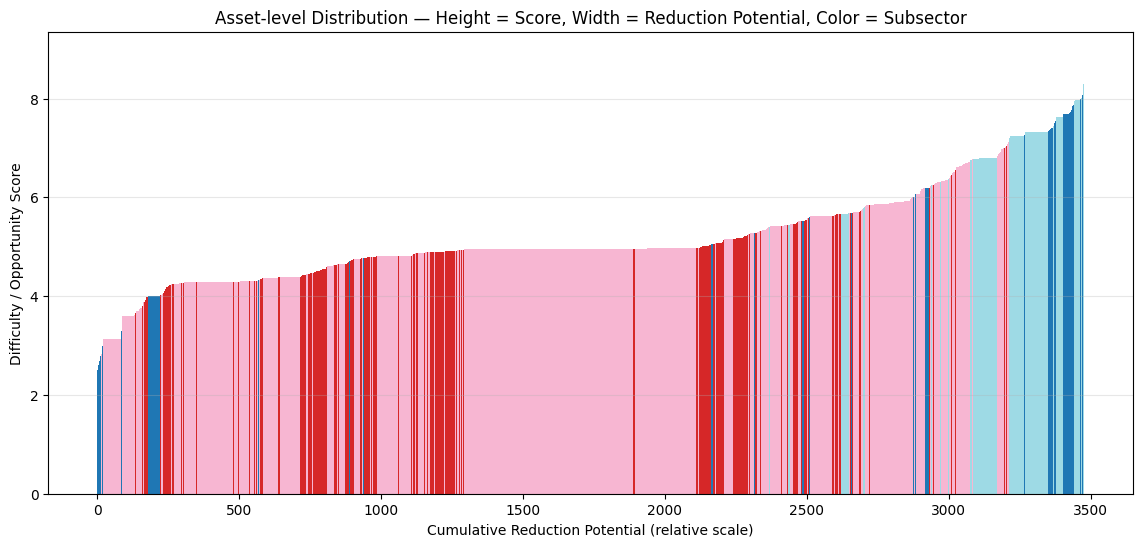

In [ ]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

%matplotlib inline

con = duckdb.connect()

df = con.execute(f'''
                 select asset_id
                    , subsector
                    , asset_difficulty_score
                    , total_emissions_reduced_per_year as reduction_potential

                 from read_parquet('asset_difficulty_score.parquet') 

                 where most_granular = true
                  and total_emissions_reduced_per_year is not null
                    and subsector in ('electricity-generation','solid-waste-disosal','iron-and-steel','cement','road-transportation')
                 ''').df()

df = df.sort_values('asset_difficulty_score')

raw_widths = df["reduction_potential"].astype(float).to_numpy()
p99 = np.quantile(raw_widths, 0.99)
scale = 1.0 / p99 if p99 > 0 else 1.0
widths = raw_widths * scale

# --- Compute x positions so bars sit side-by-side ---
x = np.cumsum(widths) - widths / 2

# --- Assign colors by subsector ---
unique_subs = df["subsector"].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_subs)))
color_map = dict(zip(unique_subs, colors))
bar_colors = [color_map[s] for s in df["subsector"]]

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.bar(
    x=x,
    height=df["asset_difficulty_score"],
    width=widths,
    color=bar_colors,
    edgecolor="none",
    align="center"
)

plt.xlabel("Cumulative Reduction Potential (relative scale)")
plt.ylabel("Difficulty / Opportunity Score")
plt.title("Asset-level Distribution — Height = Score, Width = Reduction Potential, Color = Subsector")
plt.grid(axis="y", alpha=0.3)

# --- Legend ---
# Build patches manually so we don’t clutter with duplicates
legend_elements = [Patch(facecolor=color_map[s], label=s) for s in unique_subs]
plt.legend(
    handles=legend_elements,
    title="Subsector",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.,
    fontsize=8,
    title_fontsize=9
)

plt.tight_layout()
plt.show()